In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


In [ ]:
latent_dim = 100
img_size = 32
channels = 3
batch_size = 128
learning_rate = 0.0002
epochs = 50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 170M/170M [00:33<00:00, 5.15MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128 * 8 * 8),
            nn.ReLU(),
            nn.Unflatten(1, (128, 8, 8)),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128, momentum=0.78),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64, momentum=0.78),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Tanh()
        )
    def forward(self, z):
        img = self.model(z)
        return img

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.25),
        nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
        nn.ZeroPad2d((0, 1, 0, 1)),
        nn.BatchNorm2d(64, momentum=0.8),
        nn.LeakyReLU(0.25),
        nn.Dropout(0.25),
        nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(128, momentum=0.8),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.25),
        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256, momentum=0.8),
        nn.LeakyReLU(0.25),
        nn.Dropout(0.25),
        nn.Flatten(),
        nn.Linear(256 * 5 * 5, 1),
        nn.Sigmoid()
    )
    def forward(self, img):
        validity = self.model(img)
        return validity

In [ ]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate)
adversarial_loss = nn.BCELoss()

In [ ]:
for epoch in range(epochs):
    for i, (imgs, _) in enumerate(dataloader):
        real_labels = torch.ones((imgs.size(0), 1)).to(device)
        fake_labels = torch.zeros((imgs.size(0), 1)).to(device)
        optimizer_D.zero_grad()
        real_imgs = imgs.to(device)
        real_loss = adversarial_loss(discriminator(real_imgs), real_labels)
        z = torch.randn((imgs.size(0), latent_dim)).to(device)
        fake_imgs = generator(z)
        fake_loss = adversarial_loss(discriminator(fake_imgs.detach()), fake_labels)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()
        g_loss = adversarial_loss(discriminator(fake_imgs), real_labels)
        g_loss.backward()
        optimizer_G.step()

        if i % 100 == 0:
            print(f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")


[Epoch 0/50] [Batch 0/391] [D loss: 1.40020751953125] [G loss: 0.80024653673172]
[Epoch 0/50] [Batch 100/391] [D loss: 0.3423554003238678] [G loss: 5.08437442779541]
[Epoch 0/50] [Batch 200/391] [D loss: 0.1890474259853363] [G loss: 5.825615882873535]
[Epoch 0/50] [Batch 300/391] [D loss: 0.7808594703674316] [G loss: 2.86700177192688]
[Epoch 1/50] [Batch 0/391] [D loss: 0.6391046643257141] [G loss: 5.762054920196533]
[Epoch 1/50] [Batch 100/391] [D loss: 0.024014145135879517] [G loss: 6.4294586181640625]
[Epoch 1/50] [Batch 200/391] [D loss: 0.5225138068199158] [G loss: 3.538083553314209]
[Epoch 1/50] [Batch 300/391] [D loss: 0.04894581064581871] [G loss: 5.1187920570373535]
[Epoch 2/50] [Batch 0/391] [D loss: 0.5121562480926514] [G loss: 3.2571229934692383]
[Epoch 2/50] [Batch 100/391] [D loss: 0.8901735544204712] [G loss: 2.835951328277588]
[Epoch 2/50] [Batch 200/391] [D loss: 0.3025585412979126] [G loss: 5.338494300842285]
[Epoch 2/50] [Batch 300/391] [D loss: 0.27022188901901245] 

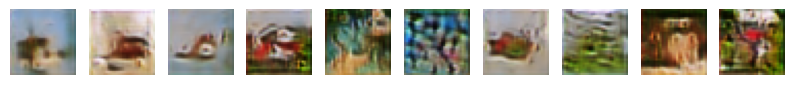

In [ ]:
def generate_images(generator, n_images=10):
    z = torch.randn(n_images, latent_dim).to(device)
    fake_imgs = generator(z).cpu().detach()
    fake_imgs = (fake_imgs + 1) / 2
    plt.figure(figsize=(10, 10))
    for i in range(n_images):
        plt.subplot(1, n_images, i+1)
        plt.imshow(fake_imgs[i].permute(1, 2, 0))
        plt.axis('off')
    plt.show()

generate_images(generator)
